In [1]:
import glob
import re
import matplotlib.backends.backend_pdf

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.mlab   as mlab
import seaborn           as sns

from scipy       import stats
from prettytable import PrettyTable
from itertools   import product

from scipy.stats import rankdata

# plots 3d
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy import interpolate

sns.set()
plt.style.use('default')

print('Done')

Done


In [2]:
#Configurando as listas que serão percorridas nos plots

dss = [
    'airfoil', 
    'concrete',
    'energyCooling',
    'energyHeating',
     'towerData',
     'wineRed',
     'wineWhite',
     'yacht'
]

_dss_labels = {
    'airfoil'       : 'Airfoil',
    'concrete'      : 'Concrete',
    'energyCooling' : 'Energy Cooling',
    'energyHeating' : 'Energy Heating',
    'towerData'     : 'Tower Data',
    'wineRed'       : 'Wine Red',
    'wineWhite'     : 'Wine White',
    'yacht'         : 'Yacth'
}
 
folds     = 5
reps      = 6

evol_path = './evolution_log/' #'../src/evolution_log/'
grid_path = './grid_log/'      #'../src/grid_log'

save_path = './plots/'

#Aqui devem ter todos os hp que estavam sendo variados no gridsearch
search_params = {
    'expolim'   : [1, 2, 3, 4, 5],
    'max_terms' : [2, 4, 6, 8, 10]    
}

In [3]:
#Definindo funções auxiliares para pegar os dados

def get_conv_mean(params, ds):
    #Essa função vai buscar por todos os folds e reps do datset passado
    #para o determinado conjunto de hiper-parâmetros (params deve ser
    #um dicionário contendo param, valor)
    
    #Exemplo de uso: get_conv_mean({'expolim':1, 'max_terms':4}, 'airfoil', 'nmse')
    
    #O retorno serão 2 arrays, com comprimento igual ao número de gerações
    #o primeiro contém a média de todas as evoluções, e o segundo os desvios padrões
    
    convergences = []
          
    for f in range(folds):
        for r in range(reps):
            
            #Sufixo dos arquivos em /evolution_log/ correspondem aos hiperparâmetros
            sufix = "-".join("=".join([k, str(v)]) for k, v in sorted(params.items()))
            
            #print(f'{evol_path}{ds}-{f}-{r}-{sufix}.csv')
            resultsDF = pd.read_csv(f'{evol_path}{ds}-{f}-{r}-{sufix}.csv')
            
            #Primeiro passo criando uma matriz com cada convergencia
            # uso essa linha para descartar partes da evolução
            conv = resultsDF['bestfit'] #[15:]
                
            convergences.append(conv)
    
    conv_mean = np.mean(convergences, axis=0)
    conv_std  = np.std(convergences, axis=0)
    
    return conv_mean, conv_std



def get_final_rmse_raw(params, ds, metric='rmse_test'):
    #Parecida com a anterior, mas não calcula a média antes de retornar
    final_rmses = []
    
    for f in range(folds):
        for r in range(reps):
            
            resultsDF = pd.read_csv(f'{grid_path}{ds}-{f}-{r}.csv')
            
            for k, v in params.items():
                #Encontrando a métrica, percorrendo cada item do dicionário params
                resultsDF = resultsDF[resultsDF[k]==v]

            #Primeiro passo criando uma matriz com cada convergencia
            final_rmses.append(resultsDF[metric].tolist()[0])
    
            if np.isnan(resultsDF[metric].tolist()[0]):
                print('NaN na configuração', ds, f, r, params)

    return final_rmses



def get_final_rmse_mean(params, ds, metric='rmse_test'):
    #Parecida com a anterior, mas só pega o RMSE final, aqui eu busco 
    #nos arquivos do grid_log, que tem todas as métricas (rmse, mae, nmse)
    #e a expressão de melhor fit
    
    #Exemplo de uso: get_final_rmse_mean({'expolim':1, 'max_terms':4}, 'airfoil')
    
    final_rmses = get_final_rmse_raw(params, ds, metric)
    
    m = np.mean(final_rmses, axis=0)
    s = np.std(final_rmses, axis=0)
    
    return m, s

def get_final_rmse_median(params, ds, metric='rmse_test'):
    #Parecida com a anterior, mas só pega o RMSE final, aqui eu busco 
    #nos arquivos do grid_log, que tem todas as métricas (rmse, mae, nmse)
    #e a expressão de melhor fit
    
    #Exemplo de uso: get_final_rmse_mean({'expolim':1, 'max_terms':4}, 'airfoil')
    
    final_rmses = get_final_rmse_raw(params, ds, metric)
    
    
    m = np.median([f for f in final_rmses if not np.isnan(f)], axis=0)
    
    return m

def get_final_rmse_best(params, ds, metric='rmse_test'):

    final_rmses = get_final_rmse_raw(params, ds, metric)
    
    m = np.min(final_rmses)
    
    return m

def dict_string(d):
    #Converte um dicionário para uma string
    
    return '\n'.join([k+'='+str(v) for k, v in d.items()])

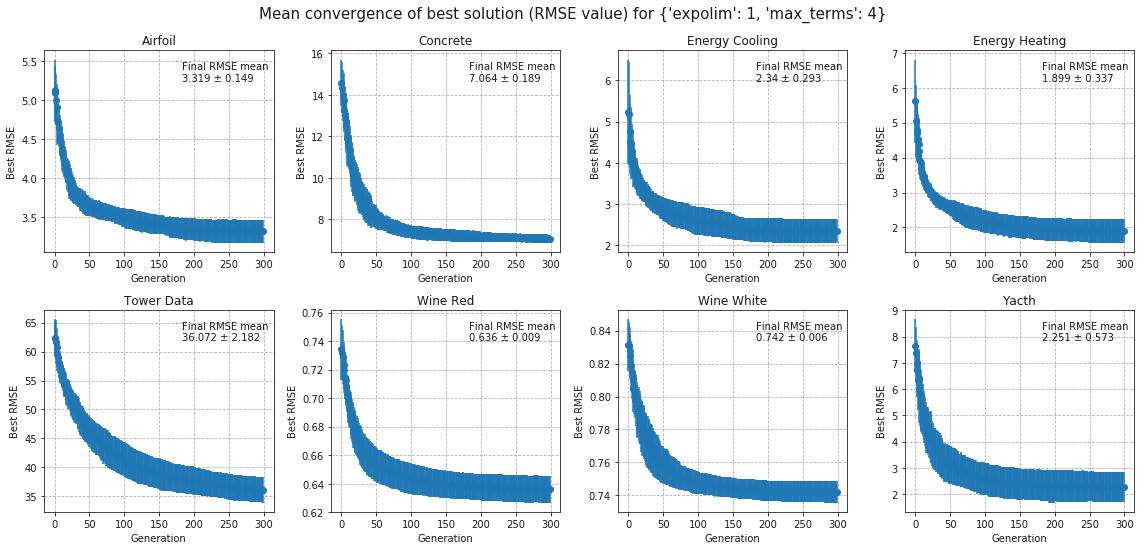

In [4]:
#Fazendo um plot para uma determinada configuração, em todos os datasets

#Essa célula é para ver um ou outro específico, a próxima plota de uma forma
#que permite uma visualização mais global

#MUDAR APENAS A PRÓXIMA LINHA -------------------------------------------------
hp_config = {'expolim':1, 'max_terms':4}


fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for (ds, ax) in zip(dss, fig.axes):
    
    conv_mean, conv_std = get_conv_mean(hp_config, ds)

    ax.errorbar(range(len(conv_mean)), conv_mean, yerr=conv_std, fmt='o')
    ax.set_title(_dss_labels[ds])
    
    ax.annotate( #média do melhor RMSE na última geração
        f'Final RMSE mean\n{round(conv_mean[-1], 3)} \xb1 {round(conv_std[-1], 3)}',
        xy=(0.60, 0.85), xycoords='axes fraction'
    )
    
    ax.set_ylabel('Best RMSE')
    ax.set_xlabel('Generation')
    ax.grid(True, linestyle='--')
    
fig.suptitle(f'Mean convergence of best solution (RMSE value) for {hp_config}',
            verticalalignment='top', fontsize = 15)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'{save_path}convergence-{hp_config}.pdf', bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


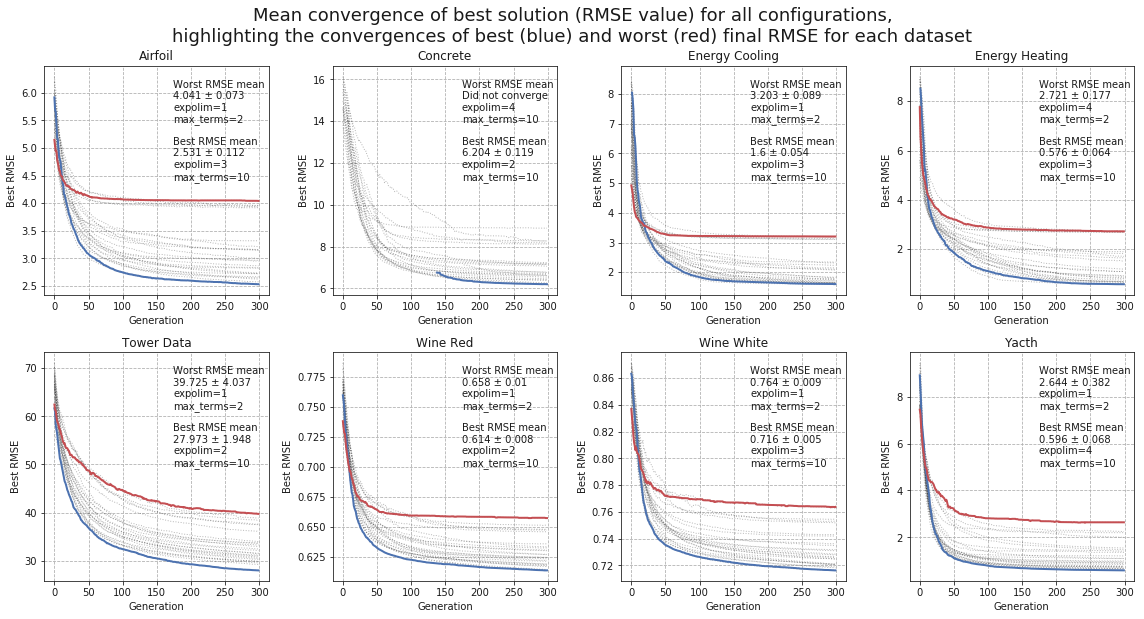

In [5]:
#Essa célula faz o mesmo que a anterior, mas coloca TODAS as configurações
#em cada plot. A convergência que termina com o pior valor é destacada em vermelho
#(para indicar o suposto limite superior), e a covnergência que termina com o melhor
#valor é destacada em azul (não é verde pois sou daltônico).
#As demais convergências tem um valor de alpha baixo, para ficarem transparentes

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))

def _get_clean_conv(line):
    # retorna uma curva de convergência que só começa quando os dados param de explodir nas gerações iniciais
    gens_without_nan  = []
    rmses_without_nan = []

    highest_nan = 0
    for xc, yc in zip(range(len(line)), line):
        if yc>1e+150:
            highest_nan = xc + 1
    
    gens_without_nan = range(highest_nan, len(line))
    rmses_without_nan = line[highest_nan:]
    
    # descomentar a linha de baixo para não omitir os NaN
    #return range(len(line)), line
    return gens_without_nan, rmses_without_nan

for (ds, ax) in zip(dss, fig.axes):
    
    conv_means      = []
    
    best_conv_mean  = [np.inf]
    best_conv_std   = np.inf
    best_hp         = {}
    
    worst_conv_mean = [-np.inf]
    worst_conv_std  = np.inf
    worst_hp        = {}
    
    #Criando todas as combinações dos hiper-parâmetros
    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
        
    for hp in hyperconfigs:
        
        conv_mean, conv_std = get_conv_mean(hp, ds)
        conv_means.append(conv_mean)
        
        if conv_mean[-1] < best_conv_mean[-1]:
            best_conv_mean = conv_mean
            best_conv_std  = conv_std
            best_hp = hp
            
        if conv_mean[-1] > worst_conv_mean[-1]:
            worst_conv_mean = conv_mean
            worst_conv_std  = conv_std
            worst_hp = hp
            
    for line in conv_means:
        #Sem plotar com std pois vai poluir muito a imagem
        gens_without_nan, rmses_without_nan = _get_clean_conv(line)
        
        #ax.plot(range(len(line)), line, 'k', alpha=0.3, linestyle='dotted', linewidth=1)
        ax.plot(gens_without_nan, rmses_without_nan, 'k', alpha=0.3, linestyle='dotted', linewidth=1)

    gens_without_nan, rmses_without_nan = _get_clean_conv(best_conv_mean)
    ax.plot(gens_without_nan, rmses_without_nan,  c='b', linestyle='solid', linewidth=2)
    
    gens_without_nan, rmses_without_nan = _get_clean_conv(worst_conv_mean)
    ax.plot(gens_without_nan, rmses_without_nan, c='r', linestyle='solid', linewidth=2)
    
    ax.set_title(_dss_labels[ds])
    
    ax.annotate( #média do melhor RMSE na última geração
        f'Best RMSE mean\n{round(best_conv_mean[-1], 3)} \xb1 {round(best_conv_std[-1], 3)}\n{dict_string(best_hp)}',
        xy=(0.575, 0.5), xycoords='axes fraction'
    )
    
    if worst_conv_mean[-1] < 1e+150:
        ax.annotate( #média do pior RMSE na última geração
            f'Worst RMSE mean\n{round(worst_conv_mean[-1], 3)} \xb1 {round(worst_conv_std[-1], 3)}\n{dict_string(worst_hp)}',
            xy=(0.575, 0.75), xycoords='axes fraction'
        )
    else:
        ax.annotate( #média do pior RMSE na última geração
            f'Worst RMSE mean\nDid not converge\n{dict_string(worst_hp)}',
            xy=(0.575, 0.75), xycoords='axes fraction'
        )
    
    ax.set_ylabel('Best RMSE')
    ax.set_xlabel('Generation')
    
    ax.grid(True, linestyle='--')
    
fig.suptitle(
    f'Mean convergence of best solution (RMSE value) for all configurations,\n\
highlighting the convergences of best (blue) and worst (red) final RMSE for each dataset',
            verticalalignment='top', fontsize = 18)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

fig.savefig(f'{save_path}convergence-allconf.pdf', bbox_inches='tight')

NaN na configuração concrete 2 0 {'expolim': 4, 'max_terms': 10}
NaN na configuração concrete 4 4 {'expolim': 4, 'max_terms': 10}
NaN na configuração concrete 0 1 {'expolim': 5, 'max_terms': 10}
NaN na configuração concrete 2 0 {'expolim': 5, 'max_terms': 10}


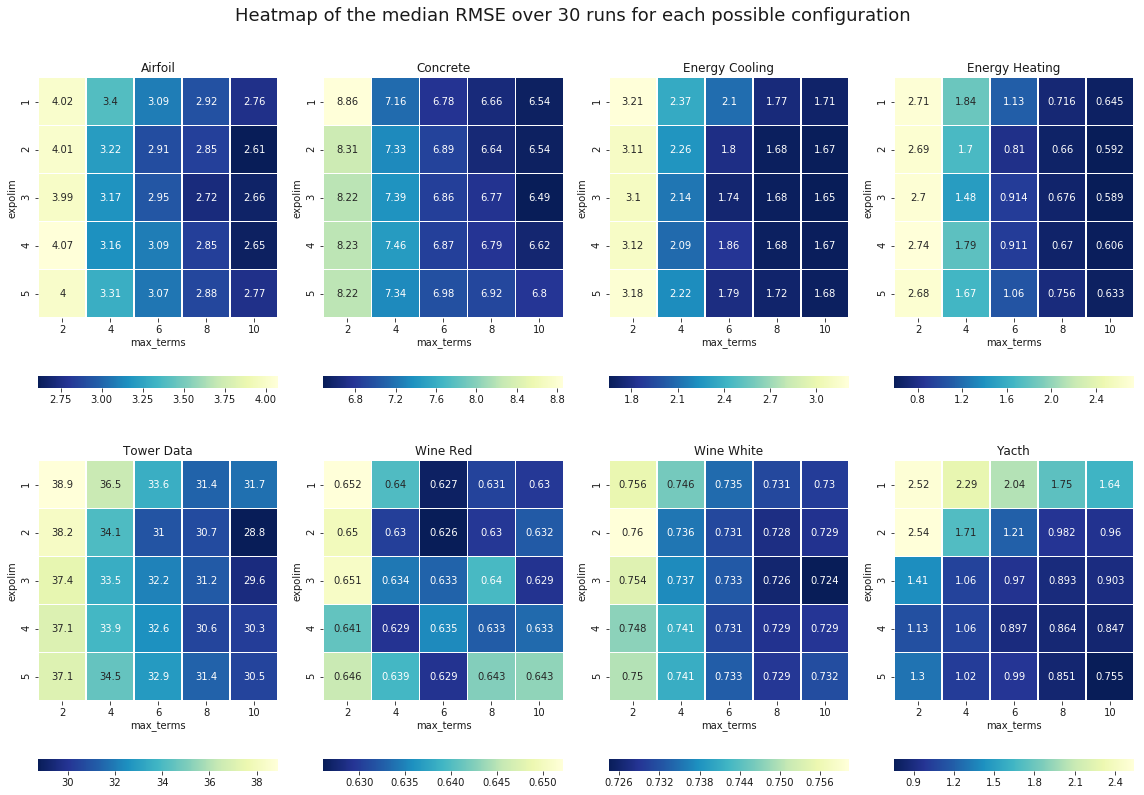

In [6]:
#Caso sejam variados apenas 2 parâmetros, podemos plotar um heatmap

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 12))
    
title = f'Heatmap of the median RMSE over 30 runs for each possible configuration'
fig.suptitle(title, verticalalignment='top', fontsize = 18)
            
for ds, ax in zip(dss, fig.axes):
    grid = []

    #Criando todas as combinações dos hiper-parâmetros
    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
        
    for hp1 in search_params['expolim']:
        
        line = []
        
        for hp2 in search_params['max_terms']:
        
            final_rmse_median = get_final_rmse_median({'expolim':hp1, 'max_terms':hp2}, ds)
            line.append(final_rmse_median)
            
        grid.append(line)
    
    # Mais escuro -> menor RMSE, melhor é o resultado; mais claro -> pior
    sns.heatmap(data=np.array(grid), ax=ax, annot=True, linewidths=.5, #center=0.0,
                 #cmap=sns.light_palette('black', reverse=True),
                 cmap="YlGnBu_r",
                 square=True,
                 cbar_kws={"orientation": "horizontal"},  fmt='.3g', #vmin=-1.0,
                 xticklabels=search_params['max_terms'], yticklabels=search_params['expolim'],
               )
    ax.set_title(_dss_labels[ds])
    ax.set_ylabel('expolim')
    ax.set_xlabel('max_terms')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'{save_path}heatmap-medianRMSE.pdf', bbox_inches='tight')

NaN na configuração concrete 2 0 {'expolim': 4, 'max_terms': 10}
NaN na configuração concrete 4 4 {'expolim': 4, 'max_terms': 10}
NaN na configuração concrete 0 1 {'expolim': 5, 'max_terms': 10}
NaN na configuração concrete 2 0 {'expolim': 5, 'max_terms': 10}


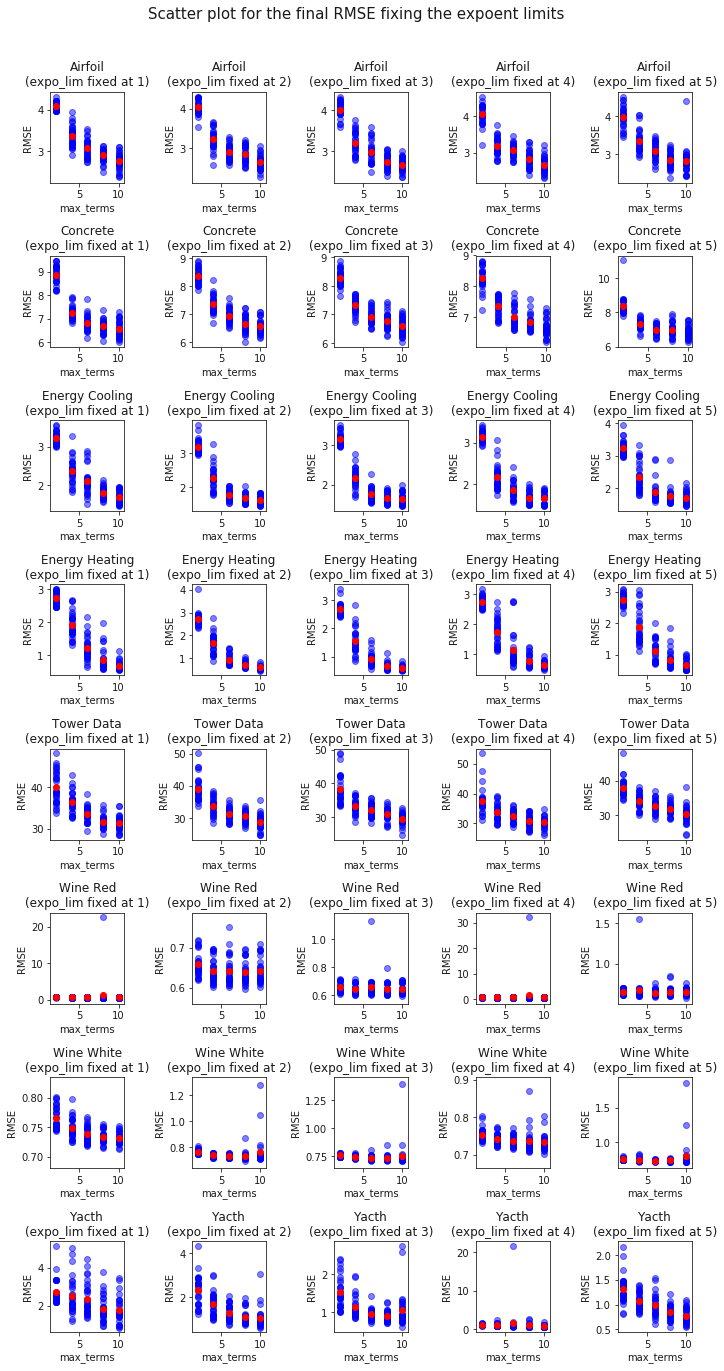

In [7]:
#Scatter plot fixando cada combinação de hp e variando apenas um
#(no caso temos só 2)

fig, axs = plt.subplots(nrows=len(dss), ncols=len(search_params['expolim']), figsize=(10, 20))

title = f'Scatter plot for the final RMSE fixing the expoent limits'
fig.suptitle(title, verticalalignment='top', fontsize = 15)

for i, ds in enumerate(dss):
    for j, expo_lim in enumerate(search_params['expolim']):

        x       = []
        y       = []
        medians = []
        for max_terms in search_params['max_terms']:
            rmses = get_final_rmse_raw({'expolim': expo_lim, 'max_terms':max_terms}, ds)
            
            medians.append(np.mean(rmses))
            
            for rmse in rmses:
                x.append(max_terms)
                y.append(rmse)
        
        axs[i][j].scatter(x, y, alpha=0.5, color='blue')
        axs[i][j].scatter(search_params['max_terms'], medians, color='red')
        axs[i][j].set_title(_dss_labels[ds] + f'\n(expo_lim fixed at {expo_lim})')
        axs[i][j].set_ylabel('RMSE')
        axs[i][j].set_xlabel('max_terms')
        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'{save_path}scatter_exponent.pdf', bbox_inches='tight')

NaN na configuração concrete 2 0 {'expolim': 4, 'max_terms': 10}
NaN na configuração concrete 4 4 {'expolim': 4, 'max_terms': 10}
NaN na configuração concrete 0 1 {'expolim': 5, 'max_terms': 10}
NaN na configuração concrete 2 0 {'expolim': 5, 'max_terms': 10}


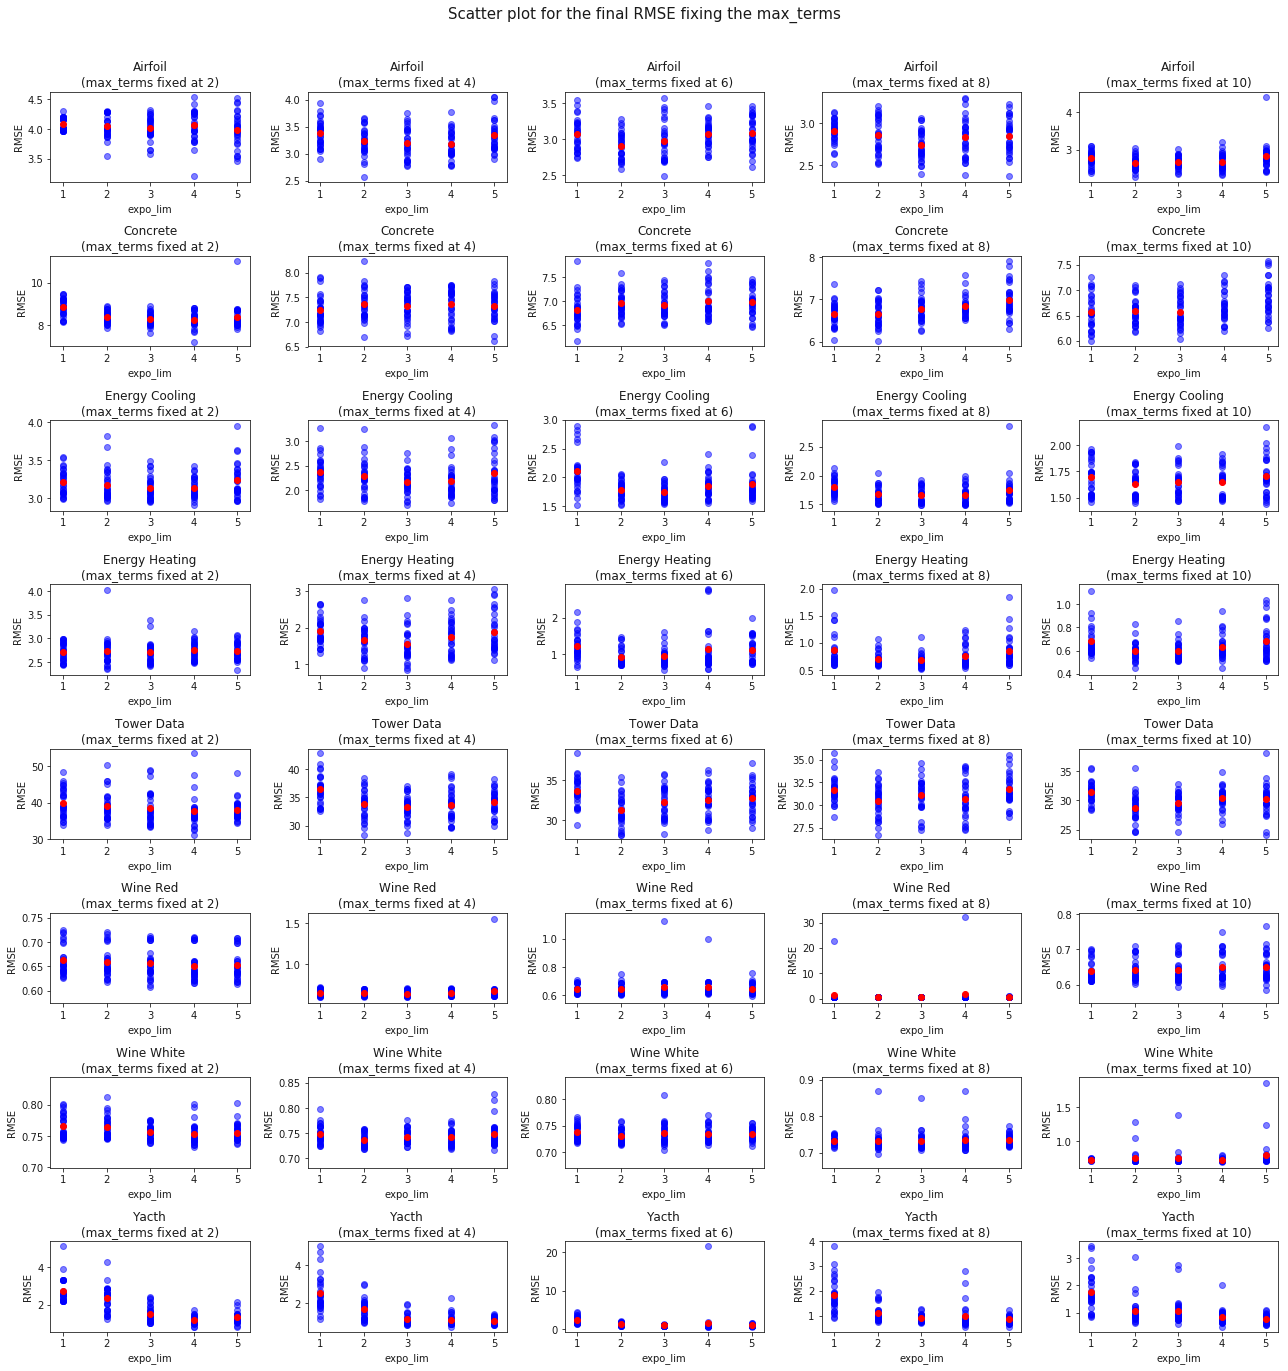

In [8]:
#Scatter plot igual o anterior, trocando o que é fixado e o que varia

fig, axs = plt.subplots(nrows=len(dss), ncols=len(search_params['max_terms']), figsize=(18, 20))

title = f'Scatter plot for the final RMSE fixing the max_terms'
fig.suptitle(title, verticalalignment='top', fontsize = 15)

for i, ds in enumerate(dss):
    for j, max_terms in enumerate(search_params['max_terms']):

        x       = []
        y       = []
        medians = []
        for expo_lim in search_params['expolim']:
            rmses = get_final_rmse_raw({'expolim': expo_lim, 'max_terms':max_terms}, ds)
            
            medians.append(np.mean(rmses))
            
            for rmse in rmses:
                x.append(expo_lim)
                y.append(rmse)
        
        axs[i][j].scatter(x, y, alpha=0.5, color='blue')
        axs[i][j].scatter(search_params['expolim'], medians, color='red')
        axs[i][j].set_title(_dss_labels[ds] + f'\n(max_terms fixed at {max_terms})')
        axs[i][j].set_ylabel('RMSE')
        axs[i][j].set_xlabel('expo_lim')
        
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'{save_path}scatter_maxterms.pdf', bbox_inches='tight')

NaN na configuração concrete 2 0 {'expolim': 4, 'max_terms': 10}
NaN na configuração concrete 4 4 {'expolim': 4, 'max_terms': 10}
NaN na configuração concrete 0 1 {'expolim': 5, 'max_terms': 10}
NaN na configuração concrete 2 0 {'expolim': 5, 'max_terms': 10}


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1874: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1881: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1889: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1890: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


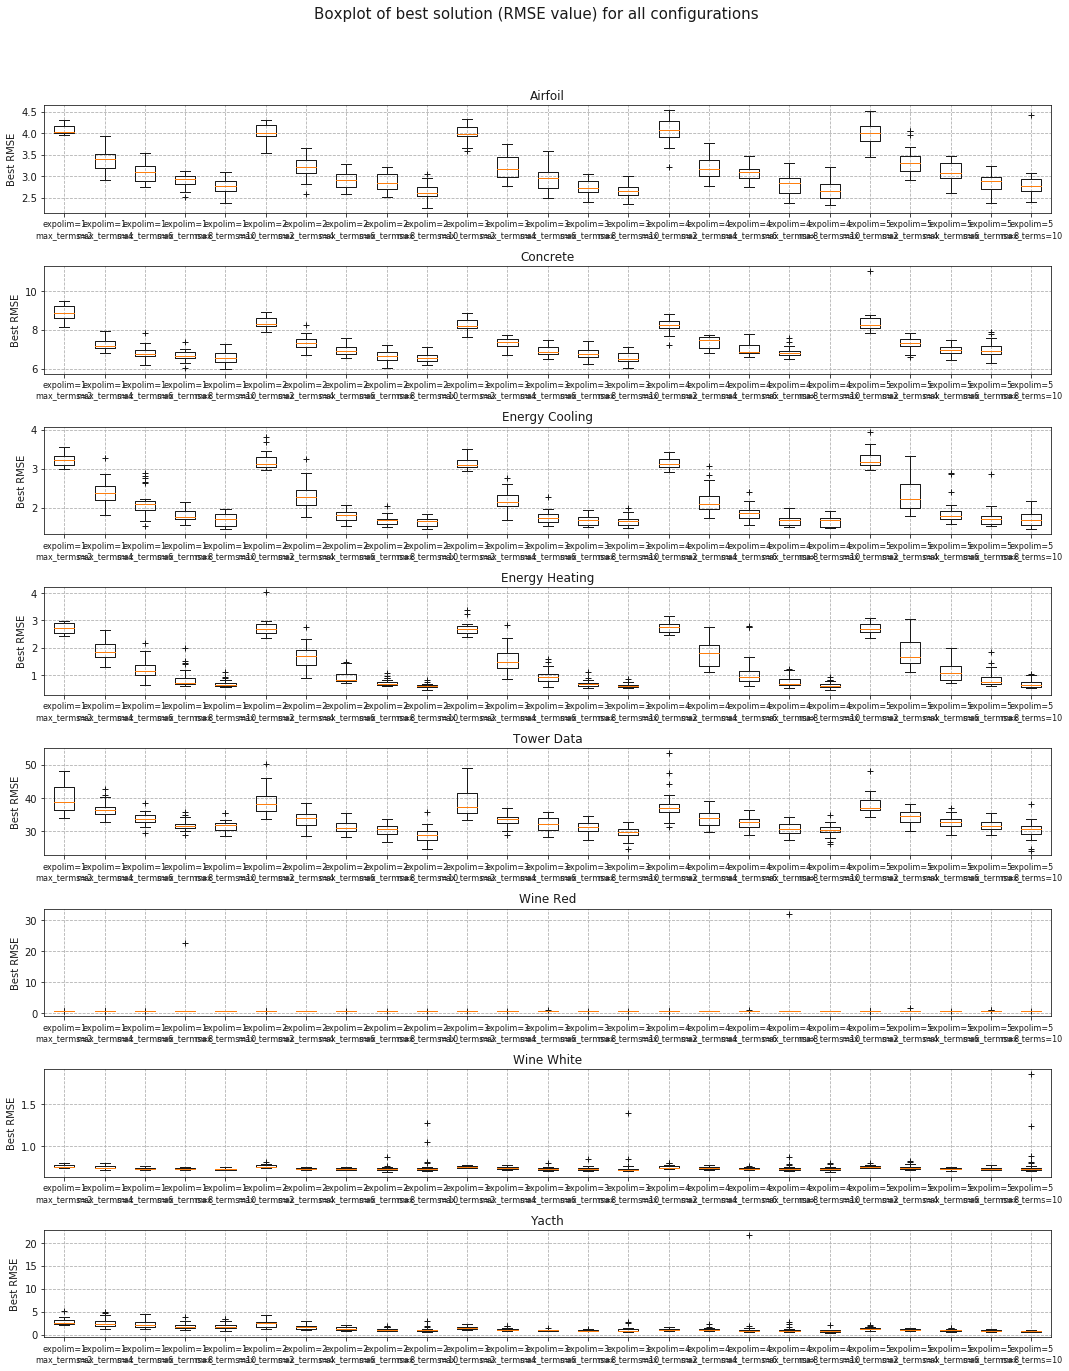

In [9]:
#Boxplot de todas as configurações


fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(15, 20))


for (ds, ax) in zip(dss, fig.axes):
    
    #Criando todas as combinações dos hiper-parâmetros
    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
        
    boxes = []
    
    for hp in hyperconfigs:
        
        boxes.append(get_final_rmse_raw(hp, ds))
            
    ax.boxplot(boxes, notch=0, sym='+', vert=1, whis=1.5)

    ticks_labels = [dict_string(hp) for hp in hyperconfigs]
    ax.set_xticklabels(ticks_labels, fontsize=8) #, rotation=45)
    ax.set_title(_dss_labels[ds])

    ax.set_ylabel('Best RMSE')
    #ax.set_xlabel('configuration')
    
    ax.grid(True, linestyle='--')
    
fig.suptitle(
    f'Boxplot of best solution (RMSE value) for all configurations',
            verticalalignment='top', fontsize = 15)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

fig.savefig(f'{save_path}cboxplots.pdf', bbox_inches='tight')

In [10]:
# Vendo a classificação de cada um

#Criando todas as combinações dos hiper-parâmetros
keys, values = zip(*search_params.items())
hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]

#Tabela para o RMSE e outra para a classificação
t = PrettyTable()
rank = PrettyTable()

#Faço replace para conseguir colar isso no latex
labelconfigs = [dict_string(hp).replace('\n', '\\') for hp in hyperconfigs]

t.field_names = [''] + labelconfigs
rank.field_names = [''] + labelconfigs

print(['Dataset'] + labelconfigs)
#Cada linha é um dataset
for ds in dss:
    row = [ds]
    r   = [ds]
    
    #Pega, para um determinado dataset, todas as possíveis configurações tem seu rmse médio coletado
    for hp, label in zip(hyperconfigs, labelconfigs):
        row.append(round(get_final_rmse_mean(hp, ds)[0], 3))

    #pego todos os rmses médios e ordeno
    scores = row[1:]
    scores.sort()
    
    #Na tabelra de ranks, coloco a ordem que ficaram depois de ordenados
    for s in row[1:]:
        r.append(int(scores.index(s)+1))
    
    #Adiciono na tabela
    rank.add_row(r)
    t.add_row(row)
    
    #Imprimo as linhas "cruas" para ficar fácil copiar e colar no latextablegenerator
    print(row)
    print(r)
    
    
#obtendo o score geral, criando a linha com média
means = ['média']

for hp, label in zip(hyperconfigs, labelconfigs):
    
    m = []

    for row in rank:
        
        #Tiro as bordinhas que o pretty table cria
        row.border=False
        row.header=False
        
        #Converto o valor para uma string
        value = row.get_string(fields=[label]).strip()
        m.append(int(value))
    
    #Calculo a média
    means.append(np.mean(m))
    
#Linha com as médias
rank.add_row(means)

#Criando a linha com a classificação geral, mesma ideia da classificação individual
geral = ['classificação geral'] 
scores = means[1:]
scores.sort()

for s in means[1:]:
    geral.append(int(scores.index(s)+1))
rank.add_row(geral)

#Imprimo as tabelas
print(means)

print(geral)

print("Tabela com médias")
print(t)
print("Tabela com classificação geral")
print(rank)

['Dataset', 'expolim=1\\max_terms=2', 'expolim=1\\max_terms=4', 'expolim=1\\max_terms=6', 'expolim=1\\max_terms=8', 'expolim=1\\max_terms=10', 'expolim=2\\max_terms=2', 'expolim=2\\max_terms=4', 'expolim=2\\max_terms=6', 'expolim=2\\max_terms=8', 'expolim=2\\max_terms=10', 'expolim=3\\max_terms=2', 'expolim=3\\max_terms=4', 'expolim=3\\max_terms=6', 'expolim=3\\max_terms=8', 'expolim=3\\max_terms=10', 'expolim=4\\max_terms=2', 'expolim=4\\max_terms=4', 'expolim=4\\max_terms=6', 'expolim=4\\max_terms=8', 'expolim=4\\max_terms=10', 'expolim=5\\max_terms=2', 'expolim=5\\max_terms=4', 'expolim=5\\max_terms=6', 'expolim=5\\max_terms=8', 'expolim=5\\max_terms=10']
['airfoil', 4.083, 3.377, 3.073, 2.903, 2.76, 4.044, 3.228, 2.91, 2.852, 2.646, 4.011, 3.201, 2.97, 2.738, 2.661, 4.061, 3.175, 3.067, 2.83, 2.671, 3.99, 3.346, 3.091, 2.847, 2.818]
['airfoil', 25, 20, 14, 10, 5, 23, 18, 11, 9, 1, 22, 17, 12, 4, 2, 24, 16, 13, 7, 3, 21, 19, 15, 8, 6]
NaN na configuração concrete 2 0 {'expolim': 4, 

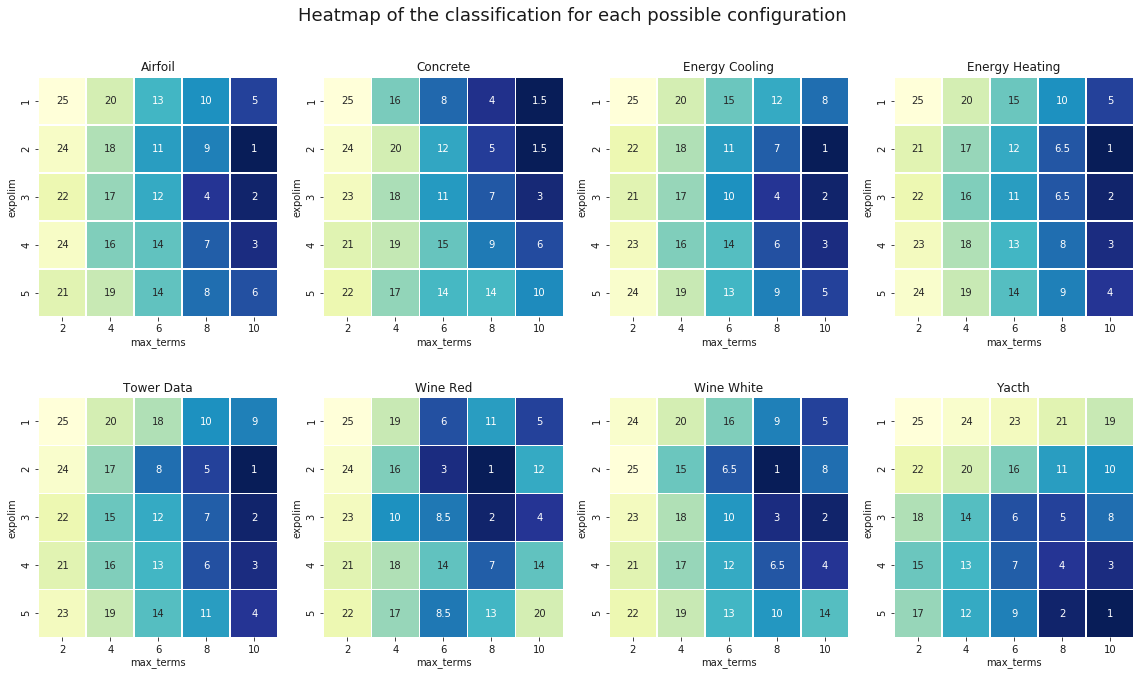

In [11]:
# Gráfico classificação de cada configuração


def classification_means(metric='rmse_test'):
    means = np.zeros( (len(search_params['expolim']), len(search_params['max_terms']), folds*reps) )

    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
                
    for f in range(folds):
        for r in range(reps):

            rmse = -1

            for hp in hyperconfigs:
            
                resultsDF = pd.read_csv(f'{grid_path}{ds}-{f}-{r}.csv')
          
                # Refinando a busca
                for k, v in hp.items():

                    #Encontrando a métrica, percorrendo cada item do dicionário params
                    resultsDF = resultsDF[resultsDF[k]==v]
                    
                rmse = resultsDF[metric].tolist()[0]
                
                x_index = search_params['expolim'].index(resultsDF['expolim'].tolist()[0])
                y_index = search_params['max_terms'].index(resultsDF['max_terms'].tolist()[0])

                means[x_index][y_index][f*reps + r] = rmse
        
    return means
        
        
        
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))

title = f'Heatmap of the classification for each possible configuration'
fig.suptitle(title, verticalalignment='top', fontsize = 18)
       
    
for (ds, ax) in zip(dss, fig.axes):
    
    #Criando todas as combinações dos hiper-parâmetros
    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
        
    
    means_classifications = classification_means()
    final_ranking = np.zeros( (len(search_params['expolim']), len(search_params['max_terms'])) )
    
    for i in range(reps*folds):
        
        fold_rep_ranking = rankdata(means_classifications[:, :, i]).reshape(means_classifications[:, :, i].shape)
        #print('fold ran', fold_rep_ranking.shape)
        final_ranking += fold_rep_ranking
        
    # Linha de baixo mostra os valores
    grid= final_ranking/(reps*folds)
    
    # linha de baixo mostra os ranks
    grid = rankdata(grid).reshape(grid.shape)
    
    #grid = rankdata(final_ranking).reshape(final_ranking.shape)

    # Mais escuro -> menor RMSE, melhor é o resultado; mais claro -> pior
    sns.heatmap(data=np.array(grid), ax=ax, annot=True, linewidths=.5, #center=0.0,
                 #cmap=sns.light_palette('black', reverse=True),
                 cbar=False,
                 cmap="YlGnBu_r", 
                 square=True,
                 cbar_kws={"orientation": "horizontal"}, #vmin=-1.0,
                 xticklabels=search_params['max_terms'], yticklabels=search_params['expolim'],
               )
    ax.set_title(_dss_labels[ds])
    ax.set_ylabel('expolim')
    ax.set_xlabel('max_terms')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'{save_path}heatmap-classifications.pdf', bbox_inches='tight')

In [12]:
#análise da variância

#se temos n hiper-parâmetros, e, para analisar a
#variância, queremos manter todos os n-1 fixos para variar apenas 1 deles por vez, tem várias configurações
#dos n-1 parâmetros que são diferentes entre si. Então teriam que ser 2 medidas: a primeira para cada
#configuração dos n-1 parâmetros conforme vamos variando o parâmetro em questão, e a segunda para obter
#um único número, juntando todas as variâncias (aqui pensei na média, ou seja, no final estamos medindo
#a média da variância de um parâmetro i, quando todos os outros n-1 estão fixados). Só que não sei se
#isso faz sentido - média da variância.

#Fixando todos menos 1, temos n-1 possíveis combinações. Vamos calcular o cv variando apenas 1 parâmetro,
#com todos os outros fixados, para cada possível combinação desses outros,
#e então pegamos a média deles
    
    
    #Caso sejam variados apenas 2 parâmetros, podemos plotar um heatmap

  
for k, v in search_params.items():
    #Para cada dataset

    print(f'vamos variar {k} = {v}')

    for ds in dss:
        
        print(ds)
        #Para cada hiper parâmetro que será variado
        
        #Crio todas as combinações dos n-1 hiper-parâmetros restantes (excluido o que será variado)
        hyperconfigs_minus_one = {**search_params}
        hyperconfigs_minus_one.pop(k)
        
        keys, values = zip(*hyperconfigs_minus_one.items())
        hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]

        #Guardar o coeficiente de variação (número que vai de 0-100%, acho que fica
        #mais justo na hora de tirar a média)
        cvs = []
        
        #hp contém todas as combinações dos n-1 hiper-parâmetros. ou seja, para cada forma diferente
        #de fixar os n-1 parâmetros, vamos utilizar essa forma variando apenas o parâmetro de interesse
        for hp in hyperconfigs:
            #print(f'configuração fixada em {hp}, variando {k} em {v}')
            
            #Vou guardar a mediana e para cada possível valor do parâmetro que estamos variando
            median_rmses = [get_final_rmse_median({**hp, **{k : varying}}, ds) for varying in v]
            
            #Vamos calcular o desvio padrão e a média desse hiper-parâmetro variando,
            #com os outros fixos (isso é feito para cada possível combinação dos outros fixos)
            final_std  = np.std(median_rmses) 
            final_mean = np.mean(median_rmses)
            
            cvs.append(final_std/final_mean)
            #print(f'CV dessa configuração: {final_std/final_mean}')

        #Vamos pegar a média dos CVs. Como CV é sempre no intervalo 0-100, e é
        #calculado em relação à média e desvio padrão, acho que faz sentido combinar todos
        #para calcular a média final
        
        #print(f'No final, são os seguintes CVs: {cvs}')
        #print(f'{k} mean CV on dataset {ds}: {np.mean(cvs)} +- {np.std(cvs)}')

        print(f'No final, são os seguintes CVs: {[str(round(cv, 3)) for cv in cvs] + \
            [str(round(np.mean(cvs), 3)) +  "pm" + str(round(np.std(cvs), 3))]}')

            
        #print(f'{k} grand CV on dataset {ds}: {np.std(cvs)/np.mean(cvs)}')
        print('--------------------------------------------------')
        #mean cvs for parameter x on dataset y
        

vamos variar expolim = [1, 2, 3, 4, 5]
airfoil
No final, são os seguintes CVs: ['0.007', '0.028', '0.026', '0.023', '0.023', '0.021pm0.007']
--------------------------------------------------
concrete
NaN na configuração concrete 2 0 {'max_terms': 10, 'expolim': 4}
NaN na configuração concrete 4 4 {'max_terms': 10, 'expolim': 4}
NaN na configuração concrete 0 1 {'max_terms': 10, 'expolim': 5}
NaN na configuração concrete 2 0 {'max_terms': 10, 'expolim': 5}
No final, são os seguintes CVs: ['0.03', '0.013', '0.01', '0.015', '0.017', '0.017pm0.007']
--------------------------------------------------
energyCooling
No final, são os seguintes CVs: ['0.014', '0.044', '0.069', '0.02', '0.012', '0.032pm0.022']
--------------------------------------------------
energyHeating
No final, são os seguintes CVs: ['0.008', '0.074', '0.121', '0.051', '0.036', '0.058pm0.038']
--------------------------------------------------
towerData
No final, são os seguintes CVs: ['0.019', '0.03', '0.026', '0.011', '

NaN na configuração concrete 2 0 {'expolim': 4, 'max_terms': 10}
NaN na configuração concrete 4 4 {'expolim': 4, 'max_terms': 10}
NaN na configuração concrete 0 1 {'expolim': 5, 'max_terms': 10}
NaN na configuração concrete 2 0 {'expolim': 5, 'max_terms': 10}


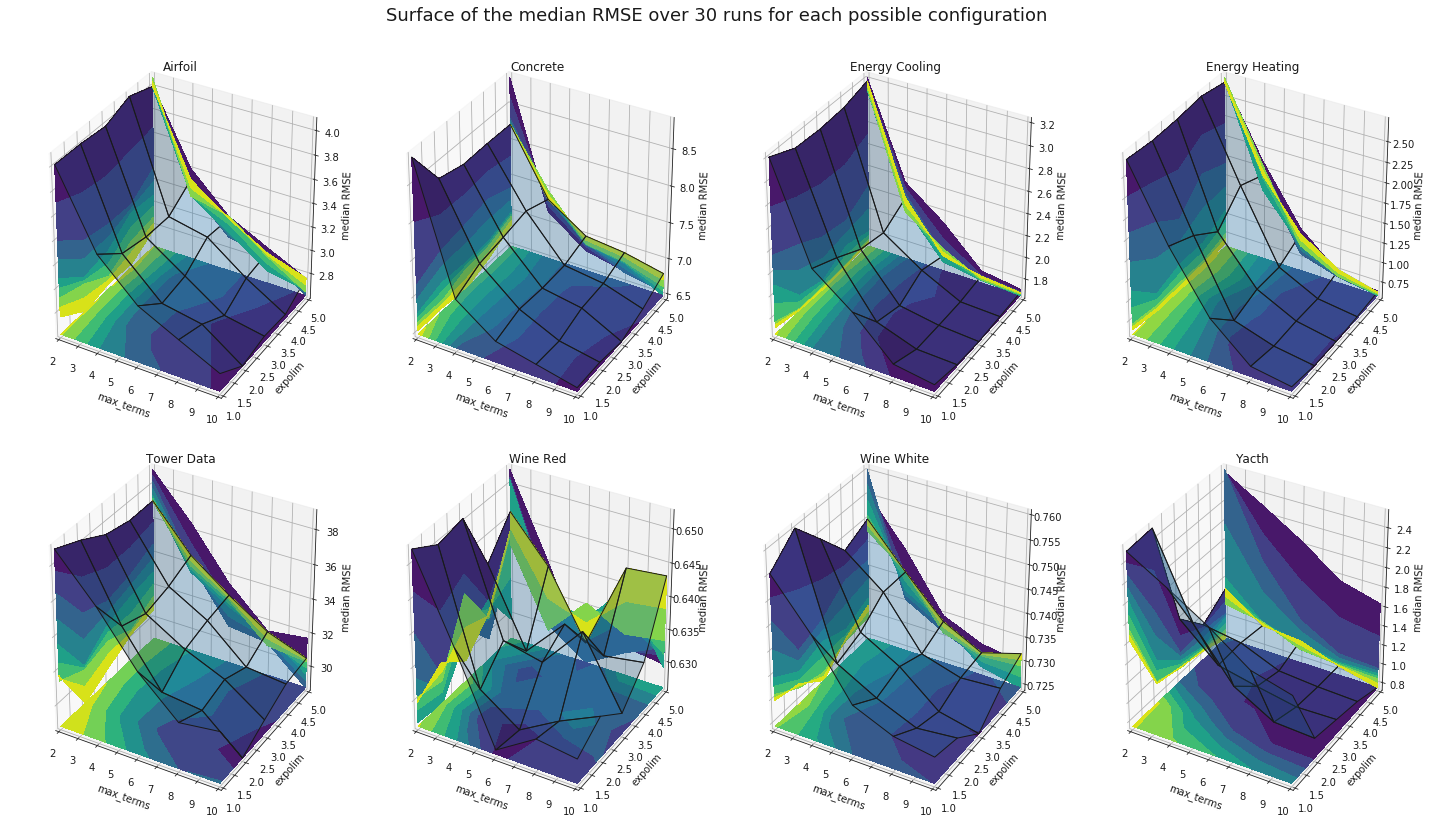

In [13]:
#Caso sejam variados apenas 2 parâmetros, podemos plotar um heatmap

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 12), subplot_kw=dict(projection='3d'))
    
title = f'Surface of the median RMSE over 30 runs for each possible configuration'
fig.suptitle(title, verticalalignment='top', fontsize = 18)
            
for ds, ax in zip(dss, fig.axes):
    grid = []

    #Criando todas as combinações dos hiper-parâmetros
    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
        
    for hp1 in search_params['expolim']:
        
        line = []
        
        for hp2 in search_params['max_terms']:
        
            final_rmse_median = get_final_rmse_median({'expolim':hp1, 'max_terms':hp2}, ds)
            line.append(final_rmse_median)
            
        grid.append(line)
    
    grid = np.array(grid)

    X, Y = np.meshgrid(search_params['max_terms'], search_params['expolim'])
    
    f = interpolate.interp2d(X, Y, grid, kind='cubic')
    xnew = np.arange(0, 5, 0.25)
    ynew = np.arange(0, 5, 0.25)
    znew = f(xnew, ynew)
    Z = grid
    #surf = ax.plot_surface(xnew, ynew, znew, cmap=cm.coolwarm,
    surf = ax.plot_surface(X, Y, grid, rstride=1,cstride=1,alpha=0.3, edgecolors='k',
                       linewidth=1, antialiased=True)
    
    cset = ax.contourf(X, Y, Z, zdir='z', offset=min(grid.ravel()))
    cset = ax.contourf(X, Y, Z, zdir='x', offset=2)
    cset = ax.contourf(X, Y, Z, zdir='y', offset=5)
    
    #ax.view_init(60, 35)
    ax.set_ylim(min(search_params['expolim']), max(search_params['expolim']))
    ax.set_xlim(min(search_params['max_terms']), max(search_params['max_terms']))
    
    ax.set_zlim(min(grid.ravel()), max(grid.ravel()))

    ax.set_title(_dss_labels[ds])
    ax.set_zlabel('median RMSE')
    ax.set_ylabel('expolim')
    ax.set_xlabel('max_terms')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'{save_path}surface-medianRMSE.pdf', bbox_inches='tight')

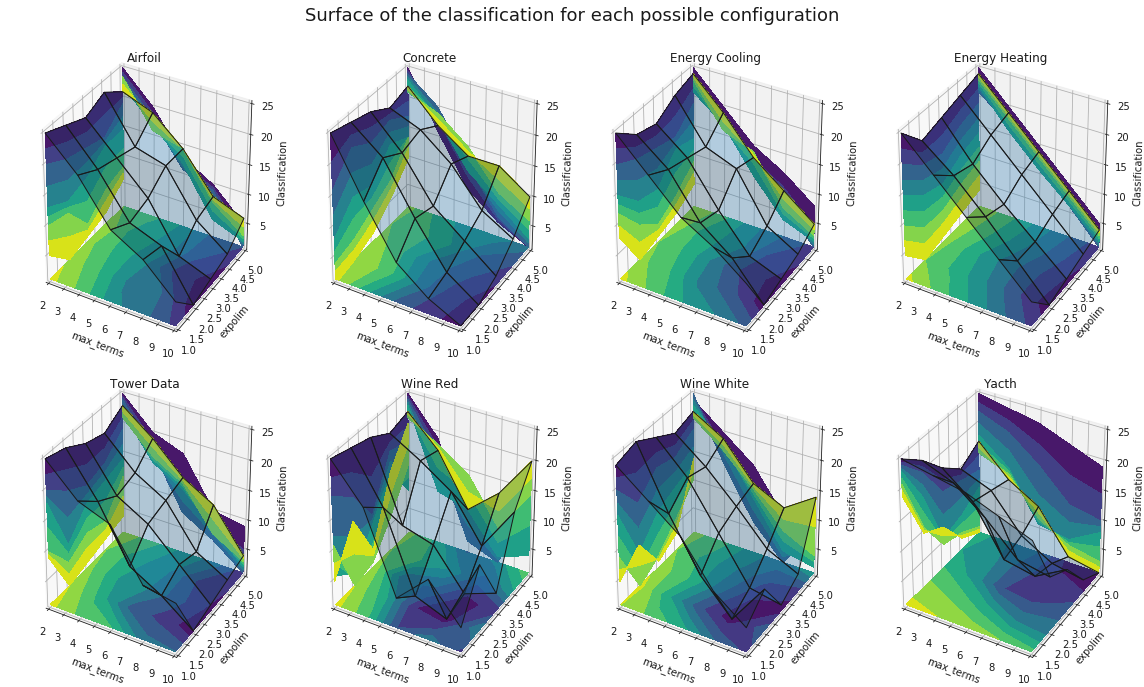

In [14]:
# Gráfico classificação de cada configuração


def classification_means(metric='rmse_test'):
    means = np.zeros( (len(search_params['expolim']), len(search_params['max_terms']), folds*reps) )

    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
                
    for f in range(folds):
        for r in range(reps):

            rmse = -1

            for hp in hyperconfigs:
            
                resultsDF = pd.read_csv(f'{grid_path}{ds}-{f}-{r}.csv')
          
                # Refinando a busca
                for k, v in hp.items():

                    #Encontrando a métrica, percorrendo cada item do dicionário params
                    resultsDF = resultsDF[resultsDF[k]==v]
                    
                rmse = resultsDF[metric].tolist()[0]
                
                x_index = search_params['expolim'].index(resultsDF['expolim'].tolist()[0])
                y_index = search_params['max_terms'].index(resultsDF['max_terms'].tolist()[0])

                means[x_index][y_index][f*reps + r] = rmse
        
    return means
        
        
        
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 10), subplot_kw=dict(projection='3d'))

title = f'Surface of the classification for each possible configuration'
fig.suptitle(title, verticalalignment='top', fontsize = 18)
       
    
for (ds, ax) in zip(dss, fig.axes):
    
    #Criando todas as combinações dos hiper-parâmetros
    keys, values = zip(*search_params.items())
    hyperconfigs = [dict(zip(keys, v)) for v in product(*values)]
        
    
    means_classifications = classification_means()
    final_ranking = np.zeros( (len(search_params['expolim']), len(search_params['max_terms'])) )
    
    for i in range(reps*folds):
        
        fold_rep_ranking = rankdata(means_classifications[:, :, i]).reshape(means_classifications[:, :, i].shape)
        #print('fold ran', fold_rep_ranking.shape)
        final_ranking += fold_rep_ranking
        
    # Linha de baixo mostra os valores
    grid= final_ranking/(reps*folds)
    
    # linha de baixo mostra os ranks
    grid = rankdata(grid).reshape(grid.shape)
    
    #grid = rankdata(final_ranking).reshape(final_ranking.shape)

    grid = np.array(grid)

    X, Y = np.meshgrid(search_params['max_terms'], search_params['expolim'])
    
    f = interpolate.interp2d(X, Y, grid, kind='cubic')
    xnew = np.arange(0, 5, 0.25)
    ynew = np.arange(0, 5, 0.25)
    znew = f(xnew, ynew)
    Z = grid
    #surf = ax.plot_surface(xnew, ynew, znew, cmap=cm.coolwarm,
    surf = ax.plot_surface(X, Y, grid, rstride=1,cstride=1,alpha=0.3, edgecolors='k',
                       linewidth=1, antialiased=True)
    
    cset = ax.contourf(X, Y, Z, zdir='z', offset=min(grid.ravel()))
    cset = ax.contourf(X, Y, Z, zdir='x', offset=2)
    cset = ax.contourf(X, Y, Z, zdir='y', offset=5)
    
    #ax.view_init(60, 35)
    ax.set_ylim(min(search_params['expolim']), max(search_params['expolim']))
    ax.set_xlim(min(search_params['max_terms']), max(search_params['max_terms']))
    
    ax.set_zlim(min(grid.ravel()), max(grid.ravel()))

    ax.set_title(_dss_labels[ds])
    ax.set_zlabel('Classification')
    ax.set_ylabel('expolim')
    ax.set_xlabel('max_terms')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

fig.savefig(f'{save_path}surface-classifications.pdf', bbox_inches='tight')